In [4]:
import sqlite3

# Use the correct path to your DB file in Drive
db_path = '/Users/hp/OneDrive/Desktop/Python/SQLITE/Actuarial_PC_Data/Actuarial_PC.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

In [5]:
#List All Tables in the Database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Tables in the database:")
for table in tables:
    print(table[0])

Tables in the database:
PNC_Claims
ClaimInvestigation


In [6]:
#Check Columns in a Specific Table
table_name = 'ClaimInvestigation'  # e.g., 'Country'
cursor.execute(f"PRAGMA table_info({table_name});")
columns = cursor.fetchall()

print(f"Columns in {table_name}:")
for col in columns:
    print(col)

Columns in ClaimInvestigation:
(0, 'ClaimNumber', 'TEXT', 0, None, 1)
(1, 'AdjusterID', 'INTEGER', 0, None, 0)
(2, 'InvestigationStatus', 'TEXT', 0, None, 0)
(3, 'InvestigationCost', 'REAL', 0, None, 0)


In [8]:
#Preview Data from a Table
cursor.execute("SELECT * FROM PNC_Claims LIMIT 5;")
rows = cursor.fetchall()

print("Sample data:")
for row in rows:
    print(row)

Sample data:
('CLM000001', 'Commercial', 2012, 9583.95, 64688.85, 23518.65, 426.83, 'Gross', 'Closed', '2016-03-14', '2018-07-23', 'AUD', 'London')
('CLM000002', 'Workers Comp', 2024, 54297.95, 94369.91, 42134.02, 3294.77, 'Gross', 'Reopened', '2014-05-30', '2015-03-05', 'CAD', 'Chicago')
('CLM000003', 'Auto Liability', 2024, 91409.74, 109411.41, 6792.0, 2010.01, 'Gross', 'Reopened', '2013-11-19', '2015-09-19', 'CAD', 'Chicago')
('CLM000004', 'Commercial', 2024, 39409.3, 102218.18, 9855.28, 9329.09, 'Net', 'Reopened', '2014-11-22', '2015-09-21', 'EUR', 'Los Angeles')
('CLM000005', 'Commercial', 2013, 83127.02, 71104.61, 14480.7, 6760.91, 'Net', 'Open', '2022-01-17', None, 'CAD', 'Los Angeles')


In [9]:
# Use Pandas for a Nicer View

import pandas as pd

df = pd.read_sql_query("SELECT * FROM claimInvestigation LIMIT 10", conn)
df.head()

,ClaimNumber,AdjusterID,InvestigationStatus,InvestigationCost
0,CLM004057,1288,Completed,4593.43
1,CLM000219,1631,In Review,159.93
2,CLM001105,1693,Completed,1478.49
3,CLM001209,1184,Pending,2293.29
4,CLM004549,1216,Completed,1663.55


In [10]:
import vanna as vn
from vanna.remote import VannaDefault

In [ ]:
vanna_api_key='ff0f0fdd4d5e4ff6ba12a9d3473df087'
vanna_model_name='actuarial_pc_model'

In [12]:
vn_model = VannaDefault(model=vanna_model_name, api_key=vanna_api_key)

In [13]:

vn_model.connect_to_sqlite('/Users/hp/OneDrive/Desktop/Python/SQLITE/Actuarial_PC_Data/Actuarial_PC.db')

In [16]:
vn_model.train(ddl="""
CREATE TABLE PNC_Claims (
    ClaimNumber VARCHAR(30) NOT NULL PRIMARY KEY,
    Reserve_Profile VARCHAR(50),
    ExposureYear INT,
    IncurredLoss FLOAT,
    UltimateLoss FLOAT,
    AssignedEarmarkedLoss FLOAT,
    FinancePremium FLOAT,
    LossType VARCHAR(10),
    ClaimStatus VARCHAR(20),
    ReportedDate DATETIME,
    SettlementDate DATETIME,
    Currency VARCHAR(5),
    GeographicalLocation VARCHAR(50)
);
""")
vn_model.train(ddl="""
CREATE TABLE ClaimInvestigation (
    ClaimNumber VARCHAR(30) NOT NULL PRIMARY KEY,
    AdjusterID INT,
    InvestigationStatus VARCHAR(20),
    InvestigationCost FLOAT,
    FOREIGN KEY (ClaimNumber) REFERENCES PNC_Claims(ClaimNumber)
);
""")

Adding ddl: 
CREATE TABLE PNC_Claims (
    ClaimNumber VARCHAR(30) NOT NULL PRIMARY KEY,
    Reserve_Profile VARCHAR(50),
    ExposureYear INT,
    IncurredLoss FLOAT,
    UltimateLoss FLOAT,
    AssignedEarmarkedLoss FLOAT,
    FinancePremium FLOAT,
    LossType VARCHAR(10),
    ClaimStatus VARCHAR(20),
    ReportedDate DATETIME,
    SettlementDate DATETIME,
    Currency VARCHAR(5),
    GeographicalLocation VARCHAR(50)
);

Adding ddl: 
CREATE TABLE ClaimInvestigation (
    ClaimNumber VARCHAR(30) NOT NULL PRIMARY KEY,
    AdjusterID INT,
    InvestigationStatus VARCHAR(20),
    InvestigationCost FLOAT,
    FOREIGN KEY (ClaimNumber) REFERENCES PNC_Claims(ClaimNumber)
);



'9928755-ddl'

In [17]:
vn_model.train(documentation="""
PNC_Claims Table:
- LossType column contains 'Gross' for total claim value before deductions and 'Net' for the amount after recoveries or adjustments.
- ClaimStatus may be 'Open', 'Closed', or 'Reopened' based on the lifecycle of the claim.
- ReportedDate and SettlementDate are stored in ISO format (YYYY-MM-DD). SettlementDate may be NULL if the claim is still open.
- Currency field holds values like 'USD', 'EUR', 'GBP', etc., representing the currency in which the claim is processed.
- GeographicalLocation indicates the branch or region handling the claim (e.g., 'New York', 'London', 'Berlin').

ClaimInvestigation Table:
- InvestigationStatus may be 'Pending', 'In Review', or 'Completed', indicating the progress of the claim investigation.
- InvestigationCost is a floating-point value representing the total cost incurred during the investigation process.
- AdjusterID is a unique numeric identifier assigned to each insurance adjuster handling the claim.
""")

Adding documentation....


'3403218-doc'

In [19]:
vn_model.train(
    question="What is the total incurred loss for all claims reported in 2023?",
    sql="""
    SELECT SUM(IncurredLoss) AS TotalIncurredLoss
    FROM PNC_Claims
    WHERE strftime('%Y', ReportedDate) = '2023';
    """
)

vn_model.train(
    question="How many claims were reported in each geographical location?",
    sql="""
    SELECT GeographicalLocation, COUNT(*) AS NumberOfClaims
    FROM PNC_Claims
    GROUP BY GeographicalLocation;
    """
)

vn_model.train(
    question="List all open claims with their ultimate loss and investigation status.",
    sql="""
    SELECT p.ClaimNumber, p.UltimateLoss, i.InvestigationStatus
    FROM PNC_Claims p
    LEFT JOIN ClaimInvestigation i ON p.ClaimNumber = i.ClaimNumber
    WHERE p.ClaimStatus = 'Open';
    """
)

vn_model.train(
    question="Which adjusters have the highest average investigation cost?",
    sql="""
    SELECT AdjusterID, AVG(InvestigationCost) AS AvgCost
    FROM ClaimInvestigation
    GROUP BY AdjusterID
    ORDER BY AvgCost DESC
    LIMIT 5;
    """
)

vn_model.train(
    question="Get the total number of claims and total investigation cost by status.",
    sql="""
    SELECT InvestigationStatus, COUNT(*) AS TotalClaims, SUM(InvestigationCost) AS TotalCost
    FROM ClaimInvestigation
    GROUP BY InvestigationStatus;
    """
)

vn_model.train(
    question="Find all claims where the ultimate loss is greater than 100,000 and reported in USD.",
    sql="""
    SELECT ClaimNumber, UltimateLoss, Currency
    FROM PNC_Claims
    WHERE UltimateLoss > 100000 AND Currency = 'USD';
    """
)

vn_model.train(
    question="What is the average time to settlement for closed claims?",
    sql="""
    SELECT AVG(julianday(SettlementDate) - julianday(ReportedDate)) AS AvgDaysToSettle
    FROM PNC_Claims
    WHERE ClaimStatus = 'Closed' AND SettlementDate IS NOT NULL;
    """
)

vn_model.train(
    question="List all claims with their adjuster and investigation status.",
    sql="""
    SELECT p.ClaimNumber, p.ClaimStatus, i.AdjusterID, i.InvestigationStatus
    FROM PNC_Claims p
    INNER JOIN ClaimInvestigation i ON p.ClaimNumber = i.ClaimNumber;
    """
)

vn_model.train(
    question="Find claims where the investigation cost exceeds the assigned earmarked loss.",
    sql="""
    SELECT p.ClaimNumber, p.AssignedEarmarkedLoss, i.InvestigationCost
    FROM PNC_Claims p
    INNER JOIN ClaimInvestigation i ON p.ClaimNumber = i.ClaimNumber
    WHERE i.InvestigationCost > p.AssignedEarmarkedLoss;
    """
)

vn_model.train(
    question="Rank claims by incurred loss within each geographical location.",
    sql="""
    SELECT ClaimNumber, GeographicalLocation, IncurredLoss,
           RANK() OVER (PARTITION BY GeographicalLocation ORDER BY IncurredLoss DESC) AS LossRank
    FROM PNC_Claims;
    """
)

vn_model.train(
    question="Get the number of high-value investigations (over 3000) by adjuster.",
    sql="""
    SELECT AdjusterID, COUNT(*) AS HighValueInvestigations
    FROM ClaimInvestigation
    WHERE InvestigationCost > 3000
    GROUP BY AdjusterID;
    """
)

vn_model.train(
    question="Which closed claims took more than 6 months to settle?",
    sql="""
    SELECT ClaimNumber, ReportedDate, SettlementDate,
           (julianday(SettlementDate) - julianday(ReportedDate)) / 30.0 AS MonthsToSettle
    FROM PNC_Claims
    WHERE ClaimStatus = 'Closed' AND SettlementDate IS NOT NULL
          AND (julianday(SettlementDate) - julianday(ReportedDate)) > 180;
    """
)

vn_model.train(
    question="Show cumulative incurred loss by exposure year.",
    sql="""
    SELECT ExposureYear, ClaimNumber, IncurredLoss,
           SUM(IncurredLoss) OVER (PARTITION BY ExposureYear ORDER BY ClaimNumber) AS CumulativeLoss
    FROM PNC_Claims;
    """
)

vn_model.train(
    question="List claims with above-average investigation cost.",
    sql="""
    SELECT i.ClaimNumber, i.InvestigationCost
    FROM ClaimInvestigation i
    WHERE i.InvestigationCost > (
        SELECT AVG(InvestigationCost) FROM ClaimInvestigation
    );
    """
)

'517c3768e4525e18251531751c9306fa-sql'

In [21]:
# Filter by month and year
vn_model.train(
    question="How many claims were reported in January 2024?",
    sql="""
    SELECT COUNT(*) AS ClaimsInJan2024
    FROM PNC_Claims
    WHERE strftime('%Y-%m', ReportedDate) = '2024-01';
    """
)

# Classify claims by severity using CASE
vn_model.train(
    question="Classify claims into severity bands based on incurred loss.",
    sql="""
    SELECT ClaimNumber, IncurredLoss,
           CASE
               WHEN IncurredLoss >= 100000 THEN 'High'
               WHEN IncurredLoss >= 50000 THEN 'Medium'
               ELSE 'Low'
           END AS SeverityBand
    FROM PNC_Claims;
    """
)

# Subquery with join
vn_model.train(
    question="Which claims have a higher investigation cost than the average for their status?",
    sql="""
    SELECT i.ClaimNumber, i.InvestigationStatus, i.InvestigationCost
    FROM ClaimInvestigation i
    WHERE i.InvestigationCost > (
        SELECT AVG(InvestigationCost)
        FROM ClaimInvestigation
        WHERE InvestigationStatus = i.InvestigationStatus
    );
    """
)

# Find most recent claims per location using window function
vn_model.train(
    question="Get the most recent claim reported in each geographical location.",
    sql="""
    SELECT ClaimNumber, GeographicalLocation, ReportedDate
    FROM (
        SELECT ClaimNumber, GeographicalLocation, ReportedDate,
               ROW_NUMBER() OVER (PARTITION BY GeographicalLocation ORDER BY ReportedDate DESC) AS rn
        FROM PNC_Claims
    )
    WHERE rn = 1;
    """
)

# Aggregate by claim status and month
vn_model.train(
    question="What is the monthly count of closed claims?",
    sql="""
    SELECT strftime('%Y-%m', SettlementDate) AS Month, COUNT(*) AS ClosedClaims
    FROM PNC_Claims
    WHERE ClaimStatus = 'Closed' AND SettlementDate IS NOT NULL
    GROUP BY Month
    ORDER BY Month;
    """
)

# Detect unusually high ultimate losses using threshold
#vn.train(
#    question="Which claims have unusually high ultimate losses over 90th percentile?",
#    sql="""
#    SELECT ClaimNumber, UltimateLoss
#    FROM PNC_Claims
#    WHERE UltimateLoss > (
#        SELECT PERCENTILE_CONT(0.9) WITHIN GROUP (ORDER BY UltimateLoss)
#        FROM PNC_Claims
#    );
#    """
#)

'089ce2cfc5d0c2c06edf37cb83712380-sql'

In [30]:
vn_model.get_training_data()

,id,training_data_type,question,content
0,1130221-sql,sql,Which closed claims took more than 6 months to...,"\n SELECT ClaimNumber, ReportedDate, Settle..."
1,1130280-sql,sql,What is the monthly count of closed claims?,"\n SELECT strftime('%Y-%m', SettlementDate)..."
2,9928754-ddl,ddl,None,\nCREATE TABLE PNC_Claims (\n ClaimNumber V...
3,1130284-sql,sql,Show me currency wise IBNR,"SELECT Currency, SUM(UltimateLoss - IncurredLo..."
4,1130279-sql,sql,Get the most recent claim reported in each geo...,"\n SELECT ClaimNumber, GeographicalLocation..."
5,3403218-doc,documentation,None,\nPNC_Claims Table:\n- LossType column contain...
6,9928755-ddl,ddl,None,\nCREATE TABLE ClaimInvestigation (\n Claim...
7,1130282-sql,sql,Show me currency wise UltimateLoss,"SELECT Currency, SUM(UltimateLoss) AS TotalUlt..."
8,1130217-sql,sql,Rank claims by incurred loss within each geogr...,"\n SELECT ClaimNumber, GeographicalLocation..."
9,1130276-sql,sql,How many claims were reported in January 2024?,\n SELECT COUNT(*) AS ClaimsInJan2024\n ...


In [26]:
vn_model.train(documentation="IBNR is calculated as UltimateLoss-IncurredLoss")

Adding documentation....


'3403284-doc'

SQL Prompt: [{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \n\nCREATE TABLE PNC_Claims (\n    ClaimNumber VARCHAR(30) NOT NULL PRIMARY KEY,\n    Reserve_Profile VARCHAR(50),\n    ExposureYear INT,\n    IncurredLoss FLOAT,\n    UltimateLoss FLOAT,\n    AssignedEarmarkedLoss FLOAT,\n    FinancePremium FLOAT,\n    LossType VARCHAR(10),\n    ClaimStatus VARCHAR(20),\n    ReportedDate DATETIME,\n    SettlementDate DATETIME,\n    Currency VARCHAR(5),\n    GeographicalLocation VARCHAR(50)\n);\n\n\n\nCREATE TABLE ClaimInvestigation (\n    ClaimNumber VARCHAR(30) NOT NULL PRIMARY KEY,\n    AdjusterID INT,\n    InvestigationStatus VARCHAR(20),\n    InvestigationCost FLOAT,\n    FOREIGN KEY (ClaimNumber) REFERENCES PNC_Claims(ClaimNumber)\n);\n\n\n\n===Additional Context \n\nIBNR is calculated as Ultim

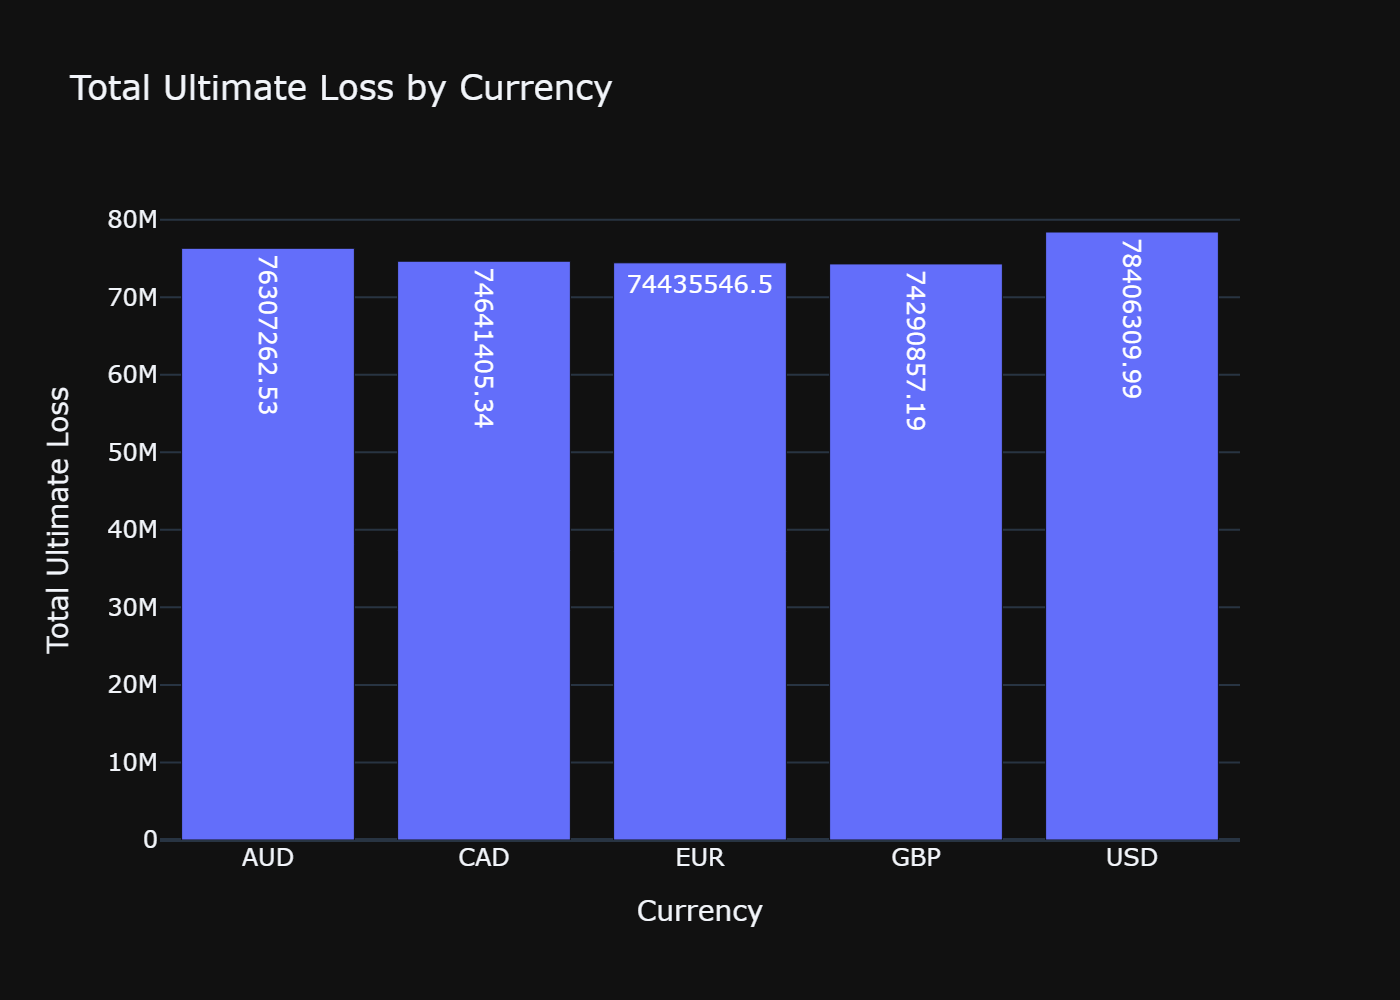

('SELECT Currency, SUM(UltimateLoss) AS TotalUltimateLoss\n    FROM PNC_Claims\n    GROUP BY Currency;',
   Currency  TotalUltimateLoss
 0      AUD        76307262.53
 1      CAD        74641405.34
 2      EUR        74435546.50
 3      GBP        74290857.19
 4      USD        78406309.99,
 Figure({
     'data': [{'text': {'bdata': 'Urge+mwxkkH2KFz1v8uRQQAAAGovv5FBXI/CpFq2kUGPwvWXirGSQQ==', 'dtype': 'f8'},
               'textposition': 'auto',
               'type': 'bar',
               'x': array(['AUD', 'CAD', 'EUR', 'GBP', 'USD'], dtype=object),
               'y': {'bdata': 'Urge+mwxkkH2KFz1v8uRQQAAAGovv5FBXI/CpFq2kUGPwvWXirGSQQ==', 'dtype': 'f8'}}],
     'layout': {'template': '...',
                'title': {'text': 'Total Ultimate Loss by Currency'},
                'xaxis': {'title': {'text': 'Currency'}},
                'yaxis': {'title': {'text': 'Total Ultimate Loss'}}}
 }))

In [ ]:
vn_model.ask("Show me currency wise UltimateLoss")

SQL Prompt: [{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \n\nCREATE TABLE PNC_Claims (\n    ClaimNumber VARCHAR(30) NOT NULL PRIMARY KEY,\n    Reserve_Profile VARCHAR(50),\n    ExposureYear INT,\n    IncurredLoss FLOAT,\n    UltimateLoss FLOAT,\n    AssignedEarmarkedLoss FLOAT,\n    FinancePremium FLOAT,\n    LossType VARCHAR(10),\n    ClaimStatus VARCHAR(20),\n    ReportedDate DATETIME,\n    SettlementDate DATETIME,\n    Currency VARCHAR(5),\n    GeographicalLocation VARCHAR(50)\n);\n\n\n\nCREATE TABLE ClaimInvestigation (\n    ClaimNumber VARCHAR(30) NOT NULL PRIMARY KEY,\n    AdjusterID INT,\n    InvestigationStatus VARCHAR(20),\n    InvestigationCost FLOAT,\n    FOREIGN KEY (ClaimNumber) REFERENCES PNC_Claims(ClaimNumber)\n);\n\n\n\n===Additional Context \n\nIBNR is calculated as Ultim

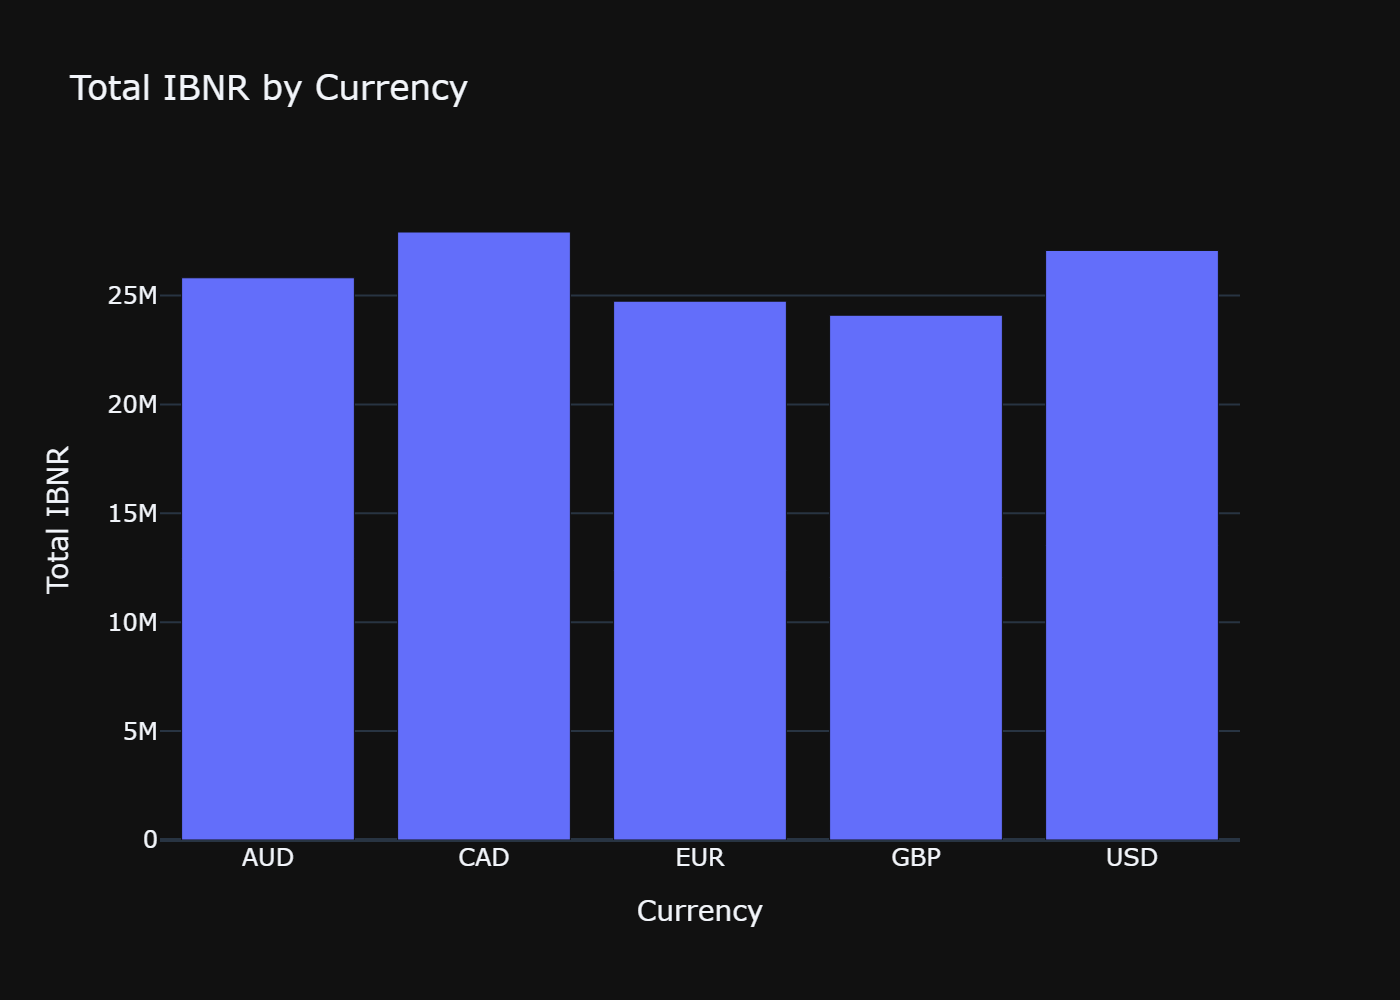

('SELECT Currency, SUM(UltimateLoss - IncurredLoss) AS TotalIBNR\n    FROM PNC_Claims\n    GROUP BY Currency;',
   Currency    TotalIBNR
 0      AUD  25817497.09
 1      CAD  27920223.59
 2      EUR  24742997.68
 3      GBP  24098488.02
 4      USD  27073121.56,
 Figure({
     'data': [{'hovertemplate': 'Currency=%{x}<br>Total IBNR=%{y}<extra></extra>',
               'legendgroup': '',
               'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
               'name': '',
               'orientation': 'v',
               'showlegend': False,
               'textposition': 'auto',
               'type': 'bar',
               'x': array(['AUD', 'CAD', 'EUR', 'GBP', 'USD'], dtype=object),
               'xaxis': 'x',
               'y': {'bdata': '16NwkRmfeEHXo3D5daB6Qa5H4VrFmHdBhetRgGv7dkGPwvUYptF5QQ==', 'dtype': 'f8'},
               'yaxis': 'y'}],
     'layout': {'barmode': 'relative',
                'legend': {'tracegroupgap': 0},
                'template': '...',
    

In [29]:
vn_model.ask("Show me currency wise IBNR")